<a href="https://colab.research.google.com/github/manufabregas/Dataset-Asistencia-a-turnos-m-dicos/blob/main/TP%203/VMF_Grupo_2_TP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import pandas as pd
import numpy as np


#Problemática 1:

 * En los **centros médicos**, la gestión de turnos se organiza según la agenda de cada especialista. Cada **médico o médica alquila su consultorio en días y horarios específicos en el centro médico**, y el costo del espacio no varía en función del número de pacientes atendidos.


* Esto significa que, desde un punto de vista económico, al **centro médico no le afecta directamente si un paciente no asiste a su cita**.
  
* Sin embargo, la clínica debe tener en cuenta la cantidad de **personal administrativo, de limpieza** y otros recursos necesarios para operar eficientemente. En días en los que las agendas de los especialistas están completamente llenas y todos los pacientes asisten, el personal del centro puede verse sobrecargado, lo que **puede llevar a la necesidad de contratar personal adicional** para manejar estas situaciones.
   
   
* Para optimizar la gestión del personal y los recursos, es crucial que las clínicas puedan prever con antelación cuántos pacientes **asistirán** a los turnos médicos cada día.

# 1)Definir el **problema de investigación a realizar**. Si se trata de aprendizaje supervisado deberán elegir si lo abordarán como un problema de **clasificación** o regresión. Explicar qué **motivación** les llevó a elegir esta problemática en particular.

---



**Problema**
El objetivo es predecir la asistencia de pacientes a sus citas médicas en un centro de salud, para optimizar la gestión del personal y recursos del centro. La clínica necesita saber cuántos pacientes asistirán cada día a fin de ajustar la cantidad de personal y recursos necesarios, evitando tanto la sobrecarga como la subutilización.


**Tipo de Aprendizaje:**
Este problema puede abordarse como un problema de clasificación supervisada. La variable objetivo (attendance) será binaria, donde:
* 1: si el paciente asiste a su cita
* 0: si no asiste.

**Motivación:**
Desde nuestro punto de vista, la clave del funcionamiento de un centro médico, radica en la calidad de los especialistas y el buen servicio. Una demora en la atención , puede significar una mala experiencia en el paciente, por lo que gestionar con eficiencia toda la cadena desde que empieza hasta que termina el día es crucial para el éxito.
Esto nos motiva a buscar la mejora continua en la gestión de hospitales, enfocándonos en optimizar la atención de turnos para lograr una mayor eficiencia en los costos y evitar la sobrecarga del personal.

# 2)Seleccionar y preparar las **variables que formarán parte de su modelo**. Si consideran que hay **otra variable a agregar** y no fue construída con anterioridad lo pueden hacer. También variar en la naturaleza de las variables. Por ejemplo, si existe una variable que es continua (alguna tasa de asistencia o edad, etc) es aquí donde la pueden categorizar de la manera que consideren interesante abordar en el modelo.

---



In [2]:
df_base=pd.read_csv("./base_turnos_hospitales.csv")
df_base = df_base[['msp_name','doc_asistance_rate', 'msp_asistance_rate','dni_asistance_rate','age_avg','qt_canc_pac_ac', 'app_days_gap',"attendance",'app_start_dt']]
df_base.head()

,msp_name,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt
0,NEUROLOGIA,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00
1,CARDIOLOGIA INFANTIL,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00
2,NEUROLOGIA,72.831978,71.085359,37.500000,60.0,0.0,33,0,2023-10-10 13:40:00
3,GINECOLOGIA Y OBSTETRICIA,89.130435,86.914721,50.000000,34.0,0.0,1,1,2023-08-23 18:20:00
4,GINECOLOGIA,76.271186,71.529776,100.000000,60.0,0.0,13,1,2023-07-27 16:15:00


In [3]:
#Recordamos la cantidad de filas y columnas
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43140 entries, 0 to 43139
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msp_name            43140 non-null  object 
 1   doc_asistance_rate  43140 non-null  float64
 2   msp_asistance_rate  43140 non-null  float64
 3   dni_asistance_rate  43140 non-null  float64
 4   age_avg             43140 non-null  float64
 5   qt_canc_pac_ac      43140 non-null  float64
 6   app_days_gap        43140 non-null  int64  
 7   attendance          43140 non-null  int64  
 8   app_start_dt        43140 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 3.0+ MB


# **TRANSFORMAMOS LA COL MSP_NAME**

---



In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Agrupamos por msp_name y contamos el total de attendance
df_total_attendance = df_base.groupby('msp_name')['attendance'].sum().reset_index()
df_total_attendance = df_total_attendance.sort_values(by='attendance')

# Agrupamos por msp_name y attendance, contamos las ocurrencias
df_attendance_bars = df_base.groupby(['msp_name', 'attendance']).size().reset_index(name='count')

# Creamos un subplot con un eje secundario
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Gráfico de líneas - Total de Attendance por Especialidad
fig.add_trace(
    go.Scatter(x=df_total_attendance['msp_name'], y=df_total_attendance['attendance'],
               name="Total Attendance", mode='lines+markers'),
    secondary_y=False
)

# Gráfico de barras - Attendance 0 y 1 por Especialidad
for attendance_val in [0, 1]:
    df_filtered = df_attendance_bars[df_attendance_bars['attendance'] == attendance_val]
    fig.add_trace(
        go.Bar(x=df_filtered['msp_name'], y=df_filtered['count'], name=f"Attendance {attendance_val}",
               opacity=0.6),
        secondary_y=True
    )

# Actualizamos los títulos y etiquetas
fig.update_layout(
    title="Total de Attendance por Especialidad (Línea) y Distribución por Attendance (Barras)",
    xaxis_title="Especialidad",
    yaxis_title="Total Attendance (Línea)",
    barmode='group',
    yaxis2_title="Cantidad de Attendance 0/1 (Barras)",
)

fig.update_layout(width=2000, height=800)


# Mostramos el gráfico
fig.show()


In [5]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 810.6 kB/s eta 0:00:00


# **TRANSFORMAMOS LA COL MSP_NAME PARA HACERLA NUMÉRICA**

---



In [6]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['msp_name'])
df_base['msp_name_encoded'] = encoder.fit_transform(df_base['msp_name'], df_base['attendance'])
df_base.head(2)

,msp_name,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt,msp_name_encoded
0,NEUROLOGIA,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00,0.681788
1,CARDIOLOGIA INFANTIL,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00,0.637736


**OTRA ALTERNATIVA DE ENCODING, PERO CON RESULTADOS SIMILARES:**

In [7]:
# import category_encoders as ce

# encoder = ce.CountEncoder(cols=['msp_name'])
# df_base['msp_name_encoded'] = encoder.fit_transform(df_base['msp_name'])
# df_base.head(2)

Probamos también Onehotencoder y parece ser el más óptimo en casos de encontrarnos con nuevos datos. No tiene el mismo problema que el encoder por frecuencias (en el caso de agregar nuevas clínicas), pero implica un tiempo de procesamiento más extenso ya que el dataframe aumenta considerablemente el tamaño.
Probamos, por otro lado, con labelencoder pero no es recomendable ya que puede inducir a un orden y traer problemas al momento de buscar un modelo adecuado al problema.


In [8]:
#Drop de la col msp_name que ya no nos hace falta
df_base=df_base.drop('msp_name',axis=1)
df_base.head(2)

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt,msp_name_encoded
0,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00,0.681788
1,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00,0.637736


# **Transformamos la Col app_start_dt para convertirla en días de la semana y hora**

In [9]:
# #Creamos la variable turno en base a la hora
# df_base['app_start_dt'] = pd.to_datetime(df_base['app_start_dt'])
# df_base['hora'] = df_base['app_start_dt'].dt.hour
# df_base['turno']=df_base['hora'].apply(lambda x: 'mañana' if 6 <= x < 12 else 'tarde' if 12 <= x < 18 else 'noche')

In [10]:
#Obtenemos el día de la semana -->  (lunes=0, martes=1, ..., domingo=6)
df_base['app_start_dt'] = pd.to_datetime(df_base['app_start_dt'])
df_base['dia_semana_num'] = df_base['app_start_dt'].dt.weekday
df_base.head(3)

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,app_start_dt,msp_name_encoded,dia_semana_num
0,72.831978,71.085359,72.727273,77.0,2.0,39,0,2023-06-23 15:40:00,0.681788,4
1,71.698113,75.919732,50.000000,7.0,0.0,48,0,2023-07-18 09:00:00,0.637736,1
2,72.831978,71.085359,37.500000,60.0,0.0,33,0,2023-10-10 13:40:00,0.681788,1


# **Transformaremos la col app_days_gap para chequear si obtenemos mejores resultados**

(No mejoró, por eso dejamos comentado el código)

In [11]:
# tertiles = pd.qcut(df_base['app_days_gap'], q=3, labels=["pocos_dias", "moderado", "alto"])
# df_base['distancia_turno'] = tertiles
# df_base.head(3)

In [12]:
# # Aplicamos One Hot Encoding a la columna 'turno'
# df_turno_encoded = pd.get_dummies(df_base[['turno']], prefix=['turno']).astype(int) #,'distancia_turno','gap'

# # Concatenamos las nuevas columnas al dataframe original
# df_base = pd.concat([df_base, df_turno_encoded], axis=1)
# df_base.head(3)

In [13]:
#Drop de la col app_start_dt y turno que ya no nos hacen falta
df_base=df_base.drop(["app_start_dt" ],axis=1) #,'distancia_turno', "turno"
df_base.head(3)

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,attendance,msp_name_encoded,dia_semana_num
0,72.831978,71.085359,72.727273,77.0,2.0,39,0,0.681788,4
1,71.698113,75.919732,50.000000,7.0,0.0,48,0,0.637736,1
2,72.831978,71.085359,37.500000,60.0,0.0,33,0,0.681788,1


# **3)Construir el modelo. A continuación se dejan algunas observaciones:**

Seleccionar el **algoritmo que consideren adecuado** para el problema planteado y las **variables elegidas**.
Dividir el conjunto de datos en **entrenamiento y prueba**, y si lo consideran, en validación. Asegurar su **replicabilidad**.
Entrenamiento del modelo.
**Optimización de hiperparámetros**.
En cada punto, justificar brevemente cada elección

---



# **4)Evaluar el modelo.**
Evaluar el rendimiento del modelo a partir de **métricas acordes** a su problema de investigación. Interpretar.
**Realizar validación cruzada**.
Análizar y evaluar **posibles mejoras del modelo frente a errores**. (Explicar por qué se cree que tal algoritmo aplicado no dió los resultados deseados o esperados)
El punto 3 y 4 deberán aplicarse sobre dos algoritmos. La idea es que realicen la construcción y evaluación de dos modelos que consideren, para luego completar la próxima actividad.

---



In [14]:
y = df_base.attendance
X = df_base.drop('attendance',axis=1)

# **ESTANDARIZAMOS LAS COLS**

---



In [15]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

x_names = X.columns
X_scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, columns=x_names)

X

,doc_asistance_rate,msp_asistance_rate,dni_asistance_rate,age_avg,qt_canc_pac_ac,app_days_gap,msp_name_encoded,dia_semana_num
0,-0.378213,-0.805742,-0.026057,1.761069,0.319952,1.005551,-0.853879,1.466294
1,-0.489198,-0.174922,-0.726693,-1.799023,-0.697647,1.502040,-1.588891,-0.675337
2,-0.378213,-0.805742,-1.112043,0.896475,-0.697647,0.674559,-0.853879,-0.675337
3,1.217113,1.259776,-0.726693,-0.425845,-0.697647,-1.090734,0.974982,0.038540
4,-0.041576,-0.747752,0.814706,0.896475,-0.697647,-0.428749,-0.270524,0.752417
...,...,...,...,...,...,...,...,...
43135,0.468418,0.264849,0.300906,-0.934429,-0.188848,-0.318418,0.974982,0.752417
43136,0.104133,0.907742,-0.212894,0.387891,-0.188848,-0.263253,0.409426,-1.389214
43137,-1.158050,-1.617433,0.814706,0.591325,-0.697647,1.667536,-0.198899,-1.389214
43138,-0.063216,0.178018,-0.726693,-0.934429,-0.697647,-0.925238,-1.141052,-1.389214


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

Decision Tree
Accuracy train Decision Tree: 0.9965%
Accuracy test Decision Tree: 0.8147%
Precision Decision Tree: 0.8761
Recall Decision Tree: 0.8690
F1-Score Decision Tree: 0.8726


Gradient Boosting
Accuracy train Gradient Boosting: 0.8644%
Accuracy test Gradient Boosting: 0.8690%
Precision Gradient Boosting: 0.8810
Recall Gradient Boosting: 0.9487
F1-Score Gradient Boosting: 0.9136


Random Forest
Accuracy train Random Forest: 0.9965%
Accuracy test Random Forest: 0.8485%
Precision Random Forest: 0.8785
Recall Random Forest: 0.9197
F1-Score Random Forest: 0.8986


SVM
Accuracy train SVM: 0.8629%
Accuracy test SVM: 0.8623%
Precision SVM: 0.8645
Recall SVM: 0.9622
F1-Score SVM: 0.9107




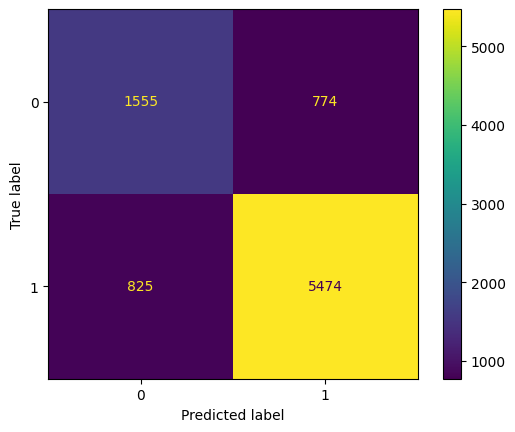

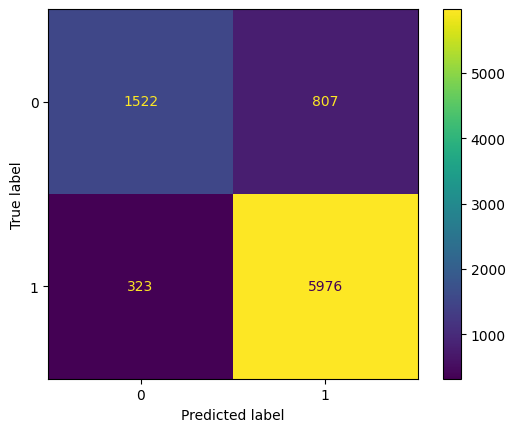

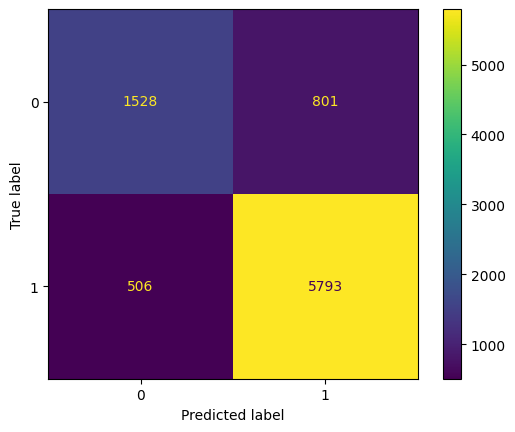

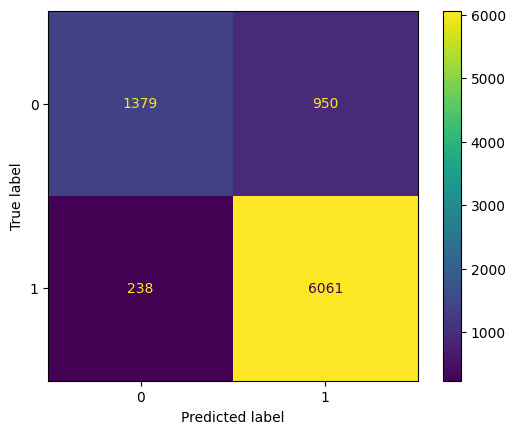

In [17]:
#Aplicamos random_state=42 para garantizar que los resultados sean siempre los mismos
clfs = [
    DecisionTreeClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42)
]


names = ['Decision Tree', 'Gradient Boosting', 'Random Forest', 'SVM']

trained_models = []
accuracy_models = []

trained_models = []
accuracy_models = []

for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)

    # training data
    train_predictions = clf.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: {train_accuracy:.4f}%")

    # test data
    test_predictions = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)

    print(f"Accuracy test {name}: {test_accuracy:.4f}%")
    print(f"Precision {name}: {precision:.4f}")
    print(f"Recall {name}: {recall:.4f}")
    print(f"F1-Score {name}: {f1:.4f}")
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
    print('\n')



    trained_models.append(clf)
    accuracy_models.append(test_accuracy * 100)


Decision Tree
AUC Decision Tree: 0.7688


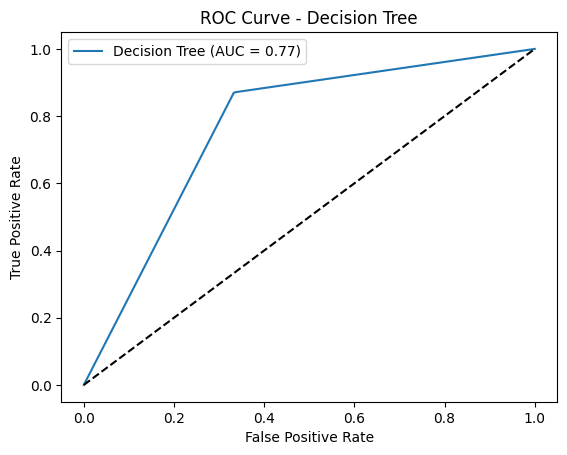

Gradient Boosting
AUC Gradient Boosting: 0.9375


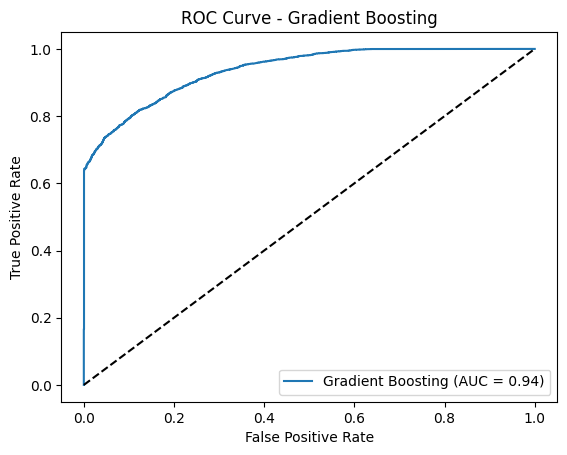

Random Forest
AUC Random Forest: 0.9227


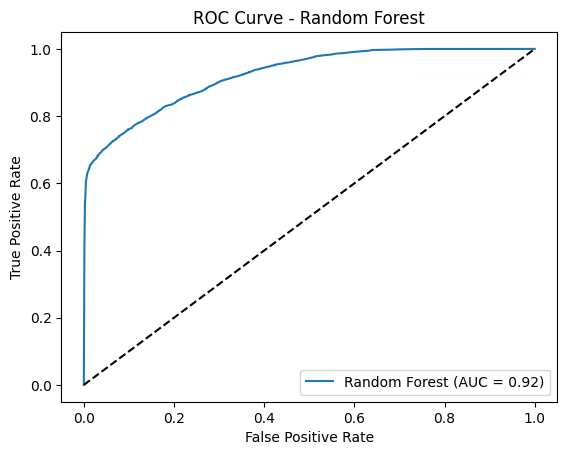

SVM
AUC SVM: 0.9038


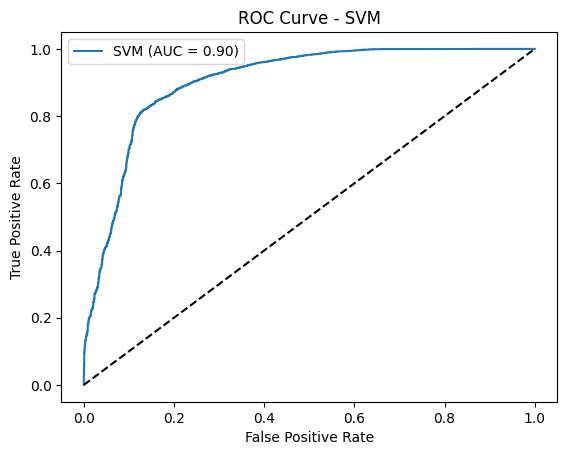

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)

    # ROC and AUC
    if hasattr(clf, "predict_proba"):  # Si el clasificador puede predecir probabilidades
        test_probs = clf.predict_proba(x_test)[:, 1]
    else:
        test_probs = clf.decision_function(x_test)

    fpr, tpr, thresholds = roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)
    print(f"AUC {name}: {roc_auc:.4f}")

    # Gráfico individual de la curva ROC
    plt.figure()  # Crea una nueva figura para cada gráfico
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Línea de adivinanza aleatoria
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='best')
    plt.show()


Decision Tree
Accuracy train Decision Tree: 0.9935%
Accuracy test Decision Tree: 0.8136%
Precision Decision Tree: 0.8758
Recall Decision Tree: 0.8678
F1-Score Decision Tree: 0.8718


Gradient Boosting
Accuracy train Gradient Boosting: 0.8644%
Accuracy test Gradient Boosting: 0.8682%
Precision Gradient Boosting: 0.8805
Recall Gradient Boosting: 0.9482
F1-Score Gradient Boosting: 0.9131


Random Forest
Accuracy train Random Forest: 0.9935%
Accuracy test Random Forest: 0.8459%
Precision Random Forest: 0.8793
Recall Random Forest: 0.9144
F1-Score Random Forest: 0.8965


SVM
Accuracy train SVM: 0.8615%
Accuracy test SVM: 0.8606%
Precision SVM: 0.8625
Recall SVM: 0.9624
F1-Score SVM: 0.9097

In [19]:
from sklearn.model_selection import cross_val_score

for clf, name in zip(clfs, names):
    scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validated accuracy for {name}: {scores.mean():.4f}")


Cross-validated accuracy for Decision Tree: 0.8137
Cross-validated accuracy for Gradient Boosting: 0.8619
Cross-validated accuracy for Random Forest: 0.8465
Cross-validated accuracy for SVM: 0.8578


# **Análisis Preliminar**

---


###  **Decision Tree y Random Forest**
 Ambos modelos muestran signos de **overfitting**, ya que la precisión en el train es mucho mayor que en el conjunto de test, es decir que no generalizan bien estos modelos. En ambos modelos se podría realizar ajustes de hiperparámetros para reducir el sobreajuste.

###  **Gradient Boosting y SVM**
 Ambos modelos tienen accuraccy similares y son los mejores modelos en términos de generalización, ya que tienen un balance entre en cuanto a rendimiento en entrenamiento y en prueba. Ambos modelos tienen un nivel alto de recall 94.82% y 96.24% respectivamente, lo que significa que son muy buenos modelos detectando la clase positiva (asistencias). En conclusión,  **Gradient Boosting** tiene un mejor F1-Score general y un mejor equilibrio entre precisión y recall. Mientras que **SVM** destaca con el recall más alto y un F1-Score de 0.9097 siendo muy bien balanceado en cuanto a precisión y recall.

# **GRID SEARCH -->Hiperámetros para Gradient Boosting y SVM**

---



In [20]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import GradientBoostingClassifier

# gb = GradientBoostingClassifier(random_state=42)

# # param_grid = {
# #     'n_estimators': [100, 200, 300],  # Número de árboles
# #     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasa de aprendizaje
# #     'max_depth': [3, 5, 7],  # Profundidad máxima del árbol
# #     'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
# #     'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
# #     'subsample': [0.8, 1.0]  # Proporción de datos a usar en cada árbol
# # }

# param_grid = {
#         'n_estimators': [200, 300],
#         'learning_rate': [0.1, 0.05],
#         'max_depth': [3, 4, 5],
#     }

# grid_search = GridSearchCV(estimator=gb, param_grid=param_grid,
#                            scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# grid_search.fit(x_train, y_train)

# print("Best hyperparameters:", grid_search.best_params_)

# best_model = grid_search.best_estimator_
# test_accuracy = best_model.score(x_test, y_test)
# # print(f"Test Accuracy of best model: {test_accuracy:.4f}")


* Fitting 5 folds for each of 12 candidates, totalling 60 fits
* Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}





In [21]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# svc = SVC(random_state=42)

# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid,
#                            scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# grid_search.fit(x_train, y_train)

# print("Best hyperparameters:", grid_search.best_params_)

# best_model = grid_search.best_estimator_
# test_accuracy = best_model.score(x_test, y_test)
# # print(f"Test Accuracy of best model: {test_accuracy:.4f}")

* Fitting 5 folds for each of 12 candidates, totalling 60 fits
* Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


# **Clasificadores Gradient Boosting y SVM con Hiperparámetros**

---



Gradient Boosting
Accuracy train Gradient Boosting: 0.8647%
Accuracy test Gradient Boosting: 0.8698%
Precision Gradient Boosting: 0.8822
Recall Gradient Boosting: 0.9484
F1-Score Gradient Boosting: 0.9141


SVM
Accuracy train SVM: 0.8594%
Accuracy test SVM: 0.8635%
Precision SVM: 0.8769
Recall SVM: 0.9457
F1-Score SVM: 0.9100




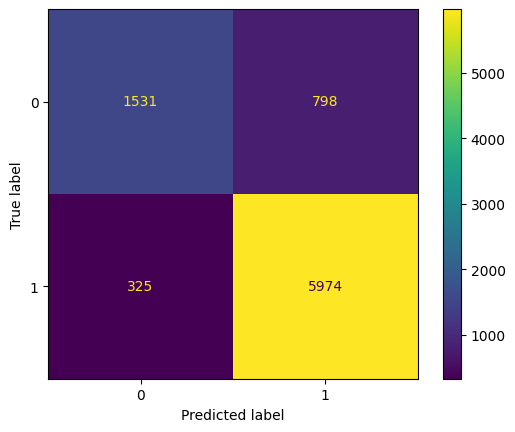

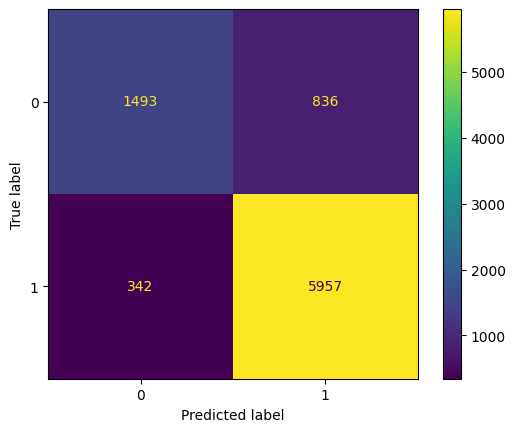

In [50]:
#Aplicamos random_state=42 para garantizar que los resultados sean siempre los mismos
clfs = [
    GradientBoostingClassifier(random_state=42, learning_rate=0.05, max_depth=3, n_estimators=200),
    SVC(random_state=42, C=1, gamma='scale', kernel='linear')
]


names = [ 'Gradient Boosting', 'SVM']

trained_models = []
accuracy_models = []

trained_models = []
accuracy_models = []

for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)

    # training data
    train_predictions = clf.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: {train_accuracy:.4f}%")

    # test data
    test_predictions = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)

    print(f"Accuracy test {name}: {test_accuracy:.4f}%")
    print(f"Precision {name}: {precision:.4f}")
    print(f"Recall {name}: {recall:.4f}")
    print(f"F1-Score {name}: {f1:.4f}")
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
    print('\n')



    trained_models.append(clf)

**Validación**

Probamos calcular las métricas con un conjunto de validación. Pero decidimos realizarlo sin este conjunto, las métricas no han variado de manera significativa.

Gradient Boosting
Accuracy train Gradient Boosting: 0.8656%
Accuracy validation Gradient Boosting: 0.8592%
Precision validation Gradient Boosting: 0.8735
Recall validation Gradient Boosting: 0.9428
F1-Score validation Gradient Boosting: 0.9068
Accuracy test Gradient Boosting: 0.8667%
Precision test Gradient Boosting: 0.8796
Recall test Gradient Boosting: 0.9471
F1-Score test Gradient Boosting: 0.9121


SVM
Accuracy train SVM: 0.8598%
Accuracy validation SVM: 0.8593%
Precision validation SVM: 0.8727
Recall validation SVM: 0.9442
F1-Score validation SVM: 0.9071
Accuracy test SVM: 0.8643%
Precision test SVM: 0.8773
Recall test SVM: 0.9465
F1-Score test SVM: 0.9106




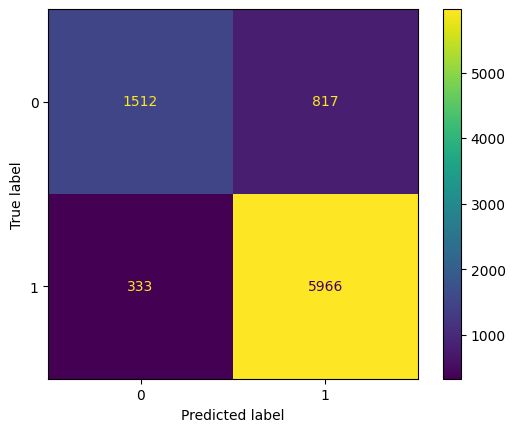

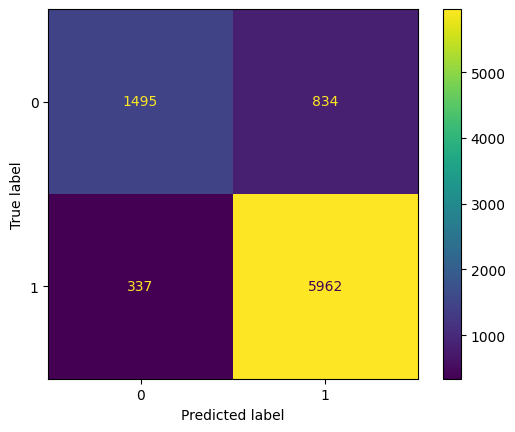

In [45]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# # Dividimos el conjunto de entrenamiento en entrenamiento y validación
# x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# # Definimos los clasificadores
# clfs = [
#     GradientBoostingClassifier(random_state=42, learning_rate=0.05, max_depth=3, n_estimators=200),
#     SVC(random_state=42, C=1, gamma='scale', kernel='linear')
# ]

# names = ['Gradient Boosting', 'SVM']

# trained_models = []

# # Entrenamos y evaluamos los modelos
# for clf, name in zip(clfs, names):
#     print(name)

#     # Ajustamos el modelo con el conjunto de entrenamiento (dividido)
#     clf.fit(x_train_split, y_train_split)

#     # Evaluación en el conjunto de entrenamiento
#     train_predictions = clf.predict(x_train_split)
#     train_accuracy = accuracy_score(y_train_split, train_predictions)
#     print(f"Accuracy train {name}: {train_accuracy:.4f}%")

#     # Evaluación en el conjunto de validación
#     val_predictions = clf.predict(x_val)
#     val_accuracy = accuracy_score(y_val, val_predictions)
#     val_precision = precision_score(y_val, val_predictions)
#     val_recall = recall_score(y_val, val_predictions)
#     val_f1 = f1_score(y_val, val_predictions)

#     print(f"Accuracy validation {name}: {val_accuracy:.4f}%")
#     print(f"Precision validation {name}: {val_precision:.4f}")
#     print(f"Recall validation {name}: {val_recall:.4f}")
#     print(f"F1-Score validation {name}: {val_f1:.4f}")

#     # Evaluación en el conjunto de test
#     test_predictions = clf.predict(x_test)
#     test_accuracy = accuracy_score(y_test, test_predictions)
#     test_precision = precision_score(y_test, test_predictions)
#     test_recall = recall_score(y_test, test_predictions)
#     test_f1 = f1_score(y_test, test_predictions)

#     print(f"Accuracy test {name}: {test_accuracy:.4f}%")
#     print(f"Precision test {name}: {test_precision:.4f}")
#     print(f"Recall test {name}: {test_recall:.4f}")
#     print(f"F1-Score test {name}: {test_f1:.4f}")

#     # Matriz de Confusión
#     ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
#     print('\n')

#     trained_models.append(clfs)

Realizamos las gráficas de ROC y AUC para Grandient Boosting y para SVM para evaluar su rendimiento.

In [34]:
# Entrenar el modelo
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
y_pred_proba_gbc = gbc.predict_proba(x_test)[:, 1]  # Probabilidad de la clase positiva

svm = SVC(probability=True)  # Necesario para obtener probabilidades
svm.fit(x_train, y_train)
y_pred_proba_svm = svm.predict_proba(x_test)[:, 1]  # Probabilidad de la clase positiva

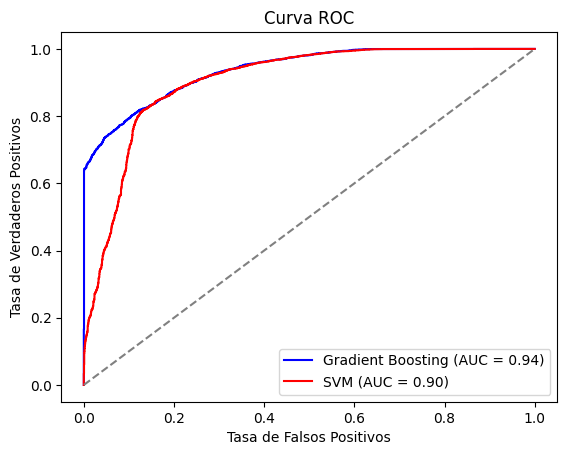

In [49]:
from sklearn.metrics import roc_curve, auc
# Calcular las métricas ROC y AUC para Gradient Boosting
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
auc_gbc = auc(fpr_gbc, tpr_gbc)

# Calcular las métricas ROC y AUC para SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

# Graficar la Curva ROC
plt.figure()
plt.plot(fpr_gbc, tpr_gbc, color='blue', label=f'Gradient Boosting (AUC = {auc_gbc:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()



*   Gradient Boosting: Tiene un AUC más alto (0.94), lo que sugiere que es el
modelo más adecuado para esta tarea de clasificación. Su curva ROC es más cercana a la esquina superior izquierda, lo que indica que tiene una mejor capacidad para equilibrar verdaderos positivos y falsos positivos.
SVM: Aunque tiene un buen rendimiento (AUC de 0.90), es ligeramente inferior en su capacidad de discriminación en comparación con el Gradient Boosting.

*   SVM: Aunque tiene un buen rendimiento (AUC de 0.90), es ligeramente inferior en su capacidad de discriminación en comparación con el Gradient Boosting.

# **RANDOM SEARCH -->Hiperámetros para Gradient Boosting**

---


In [36]:
# gb = GradientBoostingClassifier(random_state=42)

# param_dist = {
#         'n_estimators': [50, 100],
#         'learning_rate': [0.02, 0.04],
#         'max_depth': [2, 4 ],
#     }

# # Configurar RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist,
#                                    n_iter=50, scoring='accuracy', cv=5, n_jobs=-1, verbose=2, random_state=42)

# # Entrenar con RandomizedSearchCV
# random_search.fit(x_train, y_train)

# # Mostrar los mejores hiperparámetros
# print("Best hyperparameters:", random_search.best_params_)

**Best hyperparameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.04}**

Gradient Boosting
Accuracy train Gradient Boosting: 0.8639%
Accuracy test Gradient Boosting: 0.8687%
Precision Gradient Boosting: 0.8829
Recall Gradient Boosting: 0.9455
F1-Score Gradient Boosting: 0.9131




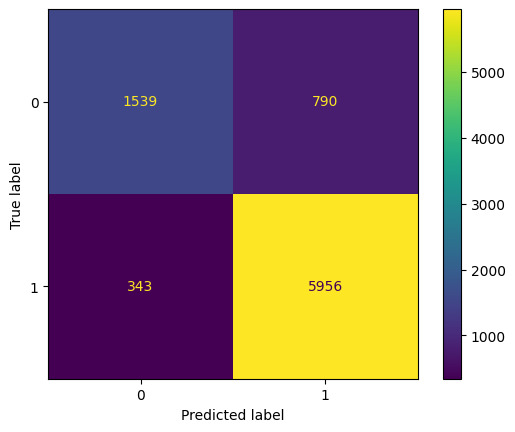

In [37]:
#Aplicamos random_state=42 para garantizar que los resultados sean siempre los mismos
clfs = [
    GradientBoostingClassifier(random_state=42, learning_rate=0.04, max_depth=4, n_estimators=100),
]


names = [ 'Gradient Boosting', 'SVM']

trained_models = []
accuracy_models = []

trained_models = []
accuracy_models = []

for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)

    # training data
    train_predictions = clf.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: {train_accuracy:.4f}%")

    # test data
    test_predictions = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions)
    recall = recall_score(y_test, test_predictions)
    f1 = f1_score(y_test, test_predictions)

    print(f"Accuracy test {name}: {test_accuracy:.4f}%")
    print(f"Precision {name}: {precision:.4f}")
    print(f"Recall {name}: {recall:.4f}")
    print(f"F1-Score {name}: {f1:.4f}")
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
    print('\n')



    trained_models.append(clf)

Tanto con Randomsearch como con Gridsearch nos dieron como resultados métricas muy similares. Hemos considerado variar los hiperparámetros, e implicaban un proceso más largo. Pero las métricas no variaron significativamente.  

# **5)Comparación de modelos. A partir de los dos modelos aplicados se deberá:**
Mencionar las principales caracteristicas (ventajas y desventajas generales) de cada algoritmo.
Fundamentar la elección de cada uno ante el problema de investigación planteado. ¿Por qué lo consideré en primer momento? ¿Por qué este algoritmo en primera instancia era el que mejores resultados podría arrojar para este conjunto de datos?
Comparar los resultados obtenidos con cada modelo a partir de las métricas, así como tiempos y costo computacional que insumieron.
Elegir un modelo final que sería presentado a sus clientes, fundamentando el por qué de su elección.
Si durante el desarrollo de este trabajo utilizan y/o aplican más de dos algoritmos pueden compartir la experiencia o resultados (teóricos) de por qué no fueron incluídos en el informe final. Se espera observar en la entrega solo los procedimientos de 2 de los modelos, nada más.

---



# **Ventajas y Desventajas de los modelos entrenados:**

---


## **1. Gradient Boosting:**
**Ventajas:**

Tiende a ofrecer buenos resultados en conjuntos de datos complejos y por lo que observamos tiene un alto control de sobreajuste, gracias a los hiperparámetros como learning_rate y n_estimators, además de que es un algoritmo que funciona bien en datasets donde las características están correlacionadas.

**Desventajas:**

Se podría mencionar que tiene un costo computacional ya que puede ser lento,  especialmente cuando se ajustan varios hiperparámetros.

## **2. Support Vector Machines (SVM):**
**Ventajas:**

El uso de diferentes kernels, lo cual Ofrece la flexibilidad de utilizar diferentes funciones kernel (lineal, polinómico, RBF), lo que permite adaptar el modelo a diferentes problemas. Además de que es un algoritmo que generaliza bien en conjuntos de datos no vistos, minimizando el sobreajuste.
**Desventajas:**

Al igual que con Gradient Boosting, este algoritmo puede ser lento, especialmente cuando se trabaja con grandes cantidades de datos, ya que implica encontrar un hiperplano óptimo a través de la maximización del margen.


# **Comparación de Resultados Obtenidos:**


---


##**Gradient Boosting:**

* Precisión en entrenamiento: 86.45%
* Precisión en prueba: 86.87%
* Precision: 0.8813
* Recall: 0.9478
* F1-Score: 0.9133



## **SVM:**
* Precisión en entrenamiento: 85.95%
* Precisión en prueba: 86.39%
* Precision: 0.8773
* Recall: 0.9459
* F1-Score: 0.9103

# **Conclusiones**

---
Ambos modelos tienen precisiones similares en el conjunto de prueba (86.87% para **Gradient Boosting** y 86.39% para **SVM**), lo que indica que ambos están generalizando bien. Gradient Boosting tiene un F1-Score ligeramente mejor (0.9133 frente a 0.9103), lo que sugiere que está manejando mejor el balance entre precisión y recall. El mejor modelo que consideramos para predecir es Gradient Boosting, ya que tiene un rendimiento superior, por lo que vemos en las métricas F1-Score y Recall.


**Otras Experiencias con Algoritmos No Incluidos:** Random Forest fue considerado inicialmente, pero el modelo mostró problemas de sobreajuste, ya que la precisión en el entrenamiento era significativamente mayor que en el conjunto de prueba. Esto lo descartó como una opción viable.
Decision Tree también fue probado, pero presentó resultados inconsistentes y un sobreajuste considerable, con una diferencia muy grande entre el entrenamiento y la prueba.

En resumen, **Gradient Boosting** es el modelo que mejor equilibra precisión, recall y generalización para este conjunto de datos, lo que lo hace ideal para ser presentado como la solución final a nuestro problema.


#**Problema emergente**

Todo era perfecto hasta que algo sucedió! Como todo, la vida real presenta sus complejidades y adversidades emergentes, que suelen poner a prueba las desiciones de los científicos de datos. Los siguientes problemas representan situaciones reales por las cuales tuvimos que atravesar y cambiar de perspectiva en un primer momento.

Problema emergente para grupo 2: Nuestro bot, Merlin, ha adquirido un nuevo cliente: el centro médico "Pentos". Este centro presenta una tasa de asistencia notablemente baja, del 61%, en comparación con otros hospitales. El cliente está desesperado por mejorar esta situación y considera que un sistema de notificaciones dirigido a pacientes que podrían no asistir es la solución. La propuesta es enviar un aviso del turno una semana antes, y si el paciente no confirma, el turno se cancelaría automáticamente para permitir la reprogramación con otro paciente. Dada esta situación particular, ¿cómo abordarían la solución para este cliente? ¿Utilizarían el modelo existente para todos los hospitales o desarrollarían un modelo específico para cada uno? ¿Qué diferencias podría implicar esta decisión? Información adicional: El centro médico Pentos lleva operando con Merlin durante 2 meses, por lo que se dispone de datos acumulados en ese periodo (650 registros de turnos médicos).




# **Posible enfoque**
Dada la particularidad de Pentos y su baja tasa de asistencia, sería recomendable al menos ajustar el modelo existente utilizando los datos del centro médico para lograr un mejor rendimiento. Esto se podría lograr:

- Entrenando el modelo general utilizando los datos globales, pero realizar un ajuste fino con los 650 registros de Pentos para adaptarlo mejor a sus particularidades.
- Crear un modelo que tenga en cuenta tanto las características generales de los hospitales como los datos específicos de Pentos. De esta manera, podrías aprovechar los patrones generales sin perder la personalización.

En cuanto a la solución de las notificaciones, podría ser efectiva, pero es esencial probar su impacto real. Tal vez, podrías realizar pruebas A/B enviando notificaciones a un grupo de pacientes y no a otro, midiendo si la tasa de confirmación mejora antes de implementar una cancelación automática. Esto permitirá mitigar riesgos y optimizar la estrategia.

En resumen, una combinación de ajuste del modelo general con personalización para Pentos podría ser la mejor ruta para equilibrar precisión y eficiencia.

[evaluar especialidades con mayores inasistencias para agregar sobreturnos esos días]

Se evaluarán los siguientes aspectos:
1- Que se apliquen los conceptos vistos con los profes en el teórico y en el práctico.

2- Que el entregable no sea solo la notebook. El informe debe tener un mensaje claro y debe presentarse en un formato legible para cualquier tipo de stakeholder. Además, se deberá entregar el dataset trabajado.

3- Capacidad de Análisis y justificación. Proactividad en la profundización de los análisis.

4- Criterio para elegir que solución aplicar en cada caso y con qué método implementarla.

5- Calidad y estilo de código.

Deadline tentativo para la entrega 16/09/2024

# **Descarga del Dataset**

---



In [38]:
# from google.colab import files

# nombre_archivo = 'entrega_final_turnos_hospitales.csv'
# df_base.to_csv(nombre_archivo, index=False)

# files.download(nombre_archivo)
